# Setup

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import itertools as it
import os.path as osp

import helpers_06

%matplotlib inline

# AlexNet

## Grab and Load the Pre-existing Weights

In [3]:
pretrained_weights, readable_labels = helpers_06.fetch_alexnet_weights_and_classes()

File bvlc_alexnet.npy already present.
File caffe_classes.py already present.


In [4]:
pretrained_weights

{'conv1': [array([[[[ -2.83153467e-02,  -7.19704404e-02,   3.78898042e-03, ...,
             -6.75531849e-03,   1.57427334e-03,  -7.34161213e-03],
           [  8.39668140e-03,  -6.77743629e-02,  -4.38617989e-02, ...,
              3.69289308e-03,  -2.12163124e-02,   2.08328497e-02],
           [ -6.01018872e-03,  -3.69863659e-02,   3.24545279e-02, ...,
              1.04015123e-03,  -1.75325349e-02,  -1.08853113e-02]],
  
          [[ -6.76262565e-03,  -9.85573977e-02,   2.73596449e-03, ...,
             -4.93216841e-03,  -4.97266697e-03,  -1.09553523e-02],
           [  3.13869417e-02,  -9.95327160e-02,  -3.94608229e-02, ...,
              8.02036002e-03,  -2.56089102e-02,   1.36672202e-02],
           [  1.04832407e-02,  -6.84838146e-02,   4.58296984e-02, ...,
              5.48922690e-04,  -1.75612103e-02,  -8.77811201e-03]],
  
          [[  1.69464536e-02,  -1.14213303e-01,  -1.37726509e-03, ...,
             -8.87093227e-03,  -8.55328236e-03,   1.48361339e-03],
           [  2.5

In [11]:
pretrained_weights['conv1'][0].shape

(11, 11, 3, 96)

In [12]:
readable_labels

['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark',
 'electric ray, crampfish, numbfish, torpedo',
 'stingray',
 'cock',
 'hen',
 'ostrich, Struthio camelus',
 'brambling, Fringilla montifringilla',
 'goldfinch, Carduelis carduelis',
 'house finch, linnet, Carpodacus mexicanus',
 'junco, snowbird',
 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 'robin, American robin, Turdus migratorius',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel, dipper',
 'kite',
 'bald eagle, American eagle, Haliaeetus leucocephalus',
 'vulture',
 'great grey owl, great gray owl, Strix nebulosa',
 'European fire salamander, Salamandra salamandra',
 'common newt, Triturus vulgaris',
 'eft',
 'spotted salamander, Ambystoma maculatum',
 'axolotl, mud puppy, Ambystoma mexicanum',
 'bullfrog, Rana catesbeiana',
 'tree frog, tree-f

## Defining Layers

##### Convolution Layers

In [6]:
def random_init_conv_layer(incoming, num_kernels, kernel_sz, 
                           strides=[1, 1], padding='SAME',
                           bval=0.01, 
                           activation_fn=tf.nn.relu, 
                           name=None):
    prev_outshape = incoming.shape.dims[-1].value
    kshape = kernel_sz + [prev_outshape, num_kernels]

    fan_in = np.prod(incoming.shape[1:]).value
    xavier_stddev = np.sqrt(2.0 / fan_in)
    
    strides = [1] + strides + [1]
    with tf.variable_scope(name, 'conv_layer'):
        w = tf.Variable(tf.truncated_normal(kshape, stddev=xavier_stddev), name='kernel')
        b = tf.Variable(tf.constant(bval, shape=[num_kernels]), name='bias')
        conv = tf.nn.conv2d(incoming, w, strides, padding, name='conv')
        z = tf.nn.bias_add(conv, b)
        return z if activation_fn is None else activation_fn(z)

In [7]:
# pt stands for "pre-trained"
def pt_conv_layer(incoming, init_weight, init_bias,
                  strides=[1, 1], padding='SAME',
                  activation_fn=tf.nn.relu, 
                  name=None):
    'expects to be given numpy arrays or tensors for weight/bias'
    strides = [1] + strides + [1]
    with tf.variable_scope(name, 'conv_layer'):
        w=tf.Variable(init_weight,name='kernel')
        b=tf.Variable(init_bias,name='bias')
        conv = tf.nn.conv2d(incoming, w, strides, padding, name='conv')
        z = tf.nn.bias_add(conv, b)
        a=activation_fn(z) if activation_fn is not None else z
        return a

##### Split Convolution


In [9]:
# pt stands for "pre-trained"
def pt_split_conv_layer(incoming, init_weight, init_bias, 
                        strides=[1, 1], padding='SAME',
                        activation_fn=tf.nn.relu, 
                        name=None):
    strides = [1] + strides + [1]
    with tf.variable_scope(name, 'split_conv_layer'):
        w = tf.Variable(init_weight, name='kernel')
        b = tf.Variable(init_bias, name='bias')
        
        if True: # ignoring the split part for now
            i_a, i_b = tf.split(incoming, 2, 3, name='split_inputs')
            w_a, w_b = tf.split(w, 2, 3, name='split_weights')

            conv_a = tf.nn.conv2d(i_a, w_a, strides, padding, name='conv_a')
            conv_b = tf.nn.conv2d(i_b, w_b, strides, padding, name='conv_b')
            merge = tf.concat([conv_a, conv_b], 3)
        else:
            conv = tf.nn.conv2d(incoming, w, strides, padding, name='conv')        
        
        z = tf.nn.bias_add(merge, b)
        a = activation_fn(z) if activation_fn is not None else z
        return a


##### AlexNet Utility Layers

In [14]:
# pt stands for "pre-trained"
def pt_alex_fc_layer(incoming, init_weights, init_biases, name=None):
    'expects to be given numpy arrays or tensors for weight/bias'
    with tf.name_scope('fully_connected'):
        return tf.nn.relu_layer(incoming, init_weights, init_biases, name=name)
    
def alex_lrn_layer(inputs):
    'lrn with some magic constants'
    return tf.nn.local_response_normalization(inputs, 2, 1.0, 2e-05, 0.75)

##### Pooling Layers

In [15]:
def pool_layer(incoming, ksize, strides, padding='VALID',
                pool_fn=tf.nn.max_pool, name=None):
    # pooling layer with stride padding
    ksize = [1] + ksize + [1]
    strides = [1] + strides + [1]    
    with tf.variable_scope(name, 'pool_layer'):
        return pool_fn(incoming, ksize, strides, padding)
    

## Defining the Main AlexNet Graph



![](images/alexnet.png)



    conv1: (11, 11, 3, 96)
    conv2: (5, 5, 48, 256)
    conv3: (3, 3, 256, 384)
    conv4: (3, 3, 192, 384)
    conv5: (3, 3, 192, 256)
    fc6: (9216, 4096)
    fc7: (4096, 4096)
    fc8: (4096, 1000)

In [67]:
def alexnet(images, init_weights):
    conv1=pt_conv_layer(images,init_weights['conv1'][0],init_weights['conv1'][1],[4,4],'VALID',name='conv1')
    lrn1=alex_lrn_layer(conv1)
    pool1=pool_layer(lrn1, [3,3], [2,2], padding='VALID', name='pool1')
    conv2=pt_split_conv_layer(pool1,init_weights['conv2'][0],init_weights['conv2'][1],name='conv2')
    lrn2=alex_lrn_layer(conv2)
    pool2=pool_layer(lrn2, [3,3], [2,2], padding='VALID', name='pool2')
    conv3=pt_conv_layer(pool2,init_weights['conv3'][0],init_weights['conv3'][1],name='conv3')
    conv4=pt_split_conv_layer(conv3,init_weights['conv4'][0],init_weights['conv4'][1],name='conv4')
    conv5=pt_split_conv_layer(conv4,init_weights['conv5'][0],init_weights['conv5'][1],name='conv5')
    pool3=pool_layer(conv5,[3,3], [2,2], padding='VALID', name='pool3')
    flat=tf.contrib.layers.flatten(pool3)
    fc6=pt_alex_fc_layer(flat,init_weights['fc6'][0],init_weights['fc6'][1],name='fc6')
    fc7=pt_alex_fc_layer(fc6,init_weights['fc7'][0],init_weights['fc7'][1],name='fc7')
    fc8=tf.nn.xw_plus_b(fc7,init_weights['fc8'][0],init_weights['fc8'][1],name='fc8')
    return fc8
    pass

## The "Loaded Weights" AlexNet Model

In [109]:
class AlexNet_Model:
    def __init__(s, img_height, img_width, init_weights):  # non-standard, for abbreviation
        s.graph = tf.Graph()
        with s.graph.as_default():
            with tf.name_scope('inputs'):
                
                s.images = tf.placeholder(tf.float32, shape=[None, None, None, 3], name="images")

                
            with tf.name_scope('rescale'):
                s.scaled_images = tf.image.resize_images(s.images, [img_height, img_width])
                

            s.logits = alexnet(s.scaled_images, init_weights)
                        
            with tf.name_scope('prediction'):
                s.softmax    = tf.nn.softmax(s.logits, name="softmax")
                s.prediction = tf.cast(tf.arg_max(s.softmax, 1), tf.int32) 

            s.init = tf.global_variables_initializer()
            
        s.session = tf.Session(graph=s.graph)
        s.session.run(s.init)

    def save(s, _dir):
        helpers_06.mkdir(_dir)
        with s.graph.as_default():
            tf.train.Saver().save(s.session, osp.join(_dir, "alexnet"))
        
        
    def predict(s, test_dict):
        pred, prob = s.session.run([s.prediction, s.softmax], feed_dict=test_dict)
        return pred, prob

## Train AlexNet

In [110]:

mm = AlexNet_Model(227, 227, init_weights=pretrained_weights)

## Test AlexNet

#####  Test Image

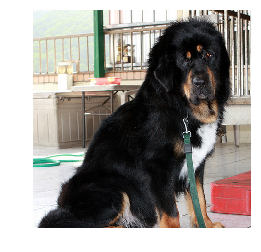

In [79]:
from scipy.misc import imread
import os.path as osp
img = imread(osp.join(local_dir, 'dog.png'))[:,:,:3]
plt.imshow(img)
plt.axis('off');

### Prediction

In [80]:
# img=np.reshape(img,(1,227,227,3))
img_batch = np.expand_dims(img, 0)
test_dict={mm.images:img_batch}
pred,prob=mm.predict(test_dict)
pred

array([205], dtype=int32)

In [83]:
top5_indices = np.argsort(prob, 1)[0][-5:]

In [84]:
top5_indices

array([267, 208, 244, 256, 205])

In [89]:
readable_labels[205]

'flat-coated retriever'

# Save  Model

In [111]:
mm.save('saved_models')

# Load  Model

In [91]:
old_alex_graph = tf.Graph()
with old_alex_graph.as_default():
    saver = tf.train.import_meta_graph("saved_models/alexnet.meta")